Non-linear Least Squares
========

# Theory
**Nonlinear Least Squares (NLS)** extends the least squares framework to model functions where parameters appear nonlinearly. Unlike linear least squares, there is no closed-form solution, so iterative optimization methods are required.

## Definition
Given a data set of $n$ points $(\mathbf{x}_i, y_i)$ and a nonlinear model function $\hat{f}(\mathbf{x}, \beta)$, we seek parameters $\beta$ that minimize:
$$
\begin{equation}
S(\beta) = \sum_{i=1}^n r_i^2 = \sum_{i=1}^n \left( y_i - \hat{f}(\mathbf{x}_i, \beta) \right)^2
\end{equation}$$

A model function is **nonlinear in parameters** when parameters cannot be separated from the model variables. For example:
$$\hat{f}(x, \beta) = \beta_1 e^{\beta_2 x}$$

Here $\beta_2$ appears inside the exponential, making this a nonlinear problem.

## Gauss-Newton Method
The **Gauss-Newton method** is an iterative algorithm that linearizes the model function using a first-order Taylor expansion around the current parameter estimate.

### Derivation
Starting from the residual vector $\vec{r}(\beta) = \vec{y} - \hat{f}(\mathbf{X}, \beta)$, we linearize around current estimate $\beta^{(k)}$:
$$
\vec{r}(\beta) \approx \vec{r}(\beta^{(k)}) + \mathbf{J}(\beta^{(k)})(\beta - \beta^{(k)})
$$

where $\mathbf{J}$ is the Jacobian matrix of the residuals with respect to parameters:
$$
J_{ij} = -\frac{\partial \hat{f}(\mathbf{x}_i, \beta)}{\partial \beta_j}
$$

Minimizing the linearized objective leads to the **normal equations**:
$$
\mathbf{J}^T \mathbf{J} \, \Delta\beta = \mathbf{J}^T \vec{r}
$$

The update rule is:
$$
\beta^{(k+1)} = \beta^{(k)} + \Delta\beta = \beta^{(k)} + (\mathbf{J}^T \mathbf{J})^{-1} \mathbf{J}^T \vec{r}
$$

### Algorithm
```
1. Initialize parameters β⁰
2. Repeat until convergence:
   a. Compute residuals r = y - f(X, β)
   b. Compute Jacobian J
   c. Solve (JᵀJ)Δβ = Jᵀr for Δβ
   d. Update β ← β + Δβ
   e. Check convergence: |Δβ| < tolerance
```

## Levenberg-Marquardt Modification
The **Levenberg-Marquardt** method adds a damping factor $\lambda$ for improved stability:
$$
(\mathbf{J}^T \mathbf{J} + \lambda \mathbf{I}) \Delta\beta = \mathbf{J}^T \vec{r}
$$

- When $\lambda$ is small, this approaches Gauss-Newton (fast convergence near solution)
- When $\lambda$ is large, this approaches gradient descent (robust far from solution)

# Implementation

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

## Parameters

In [2]:
# Data generation parameters
N = 30                    # number of data points
a, b = 0, 5               # interval
noise_std = 0.5           # noise standard deviation

# True parameters for synthetic data
true_beta = np.array([2.5, 0.8])  # [amplitude, decay rate]

# Algorithm parameters
max_iter = 100
tolerance = 1e-8

## Algorithm

```mermaid
    flowchart LR
        init(Initialize β⁰) --> compute_r(Compute residuals r)
        compute_r --> compute_J(Compute Jacobian J)
        compute_J --> solve(Solve for Δβ)
        solve --> update(Update β)
        update --> check{Converged?}
        check -->|No| compute_r
        check -->|Yes| done(Return β)
```

In [3]:
def gauss_newton(x: np.ndarray, y: np.ndarray, 
                 model: Callable, jacobian: Callable,
                 beta0: np.ndarray, 
                 max_iter: int = 100, 
                 tol: float = 1e-8) -> tuple[np.ndarray, list, int]:
    '''
    Gauss-Newton method for nonlinear least squares optimization.
    
    Args:
        x: Independent variable data points
        y: Observed values (dependent variable)
        model: Model function f(x, beta) -> y_predicted
        jacobian: Function returning Jacobian matrix J(x, beta)
        beta0: Initial parameter guess
        max_iter: Maximum number of iterations
        tol: Convergence tolerance
    
    Returns:
        Tuple of (optimal parameters, history of beta values, iterations used)
    '''
    beta = beta0.copy().astype(float)
    history = [beta.copy()]
    
    for iteration in range(max_iter):
        # Compute residuals: r = y - f(x, beta)
        r = y - model(x, beta)
        
        # Compute Jacobian (negative of partial derivatives of f w.r.t. beta)
        J = jacobian(x, beta)
        
        # Solve normal equations: (J^T J) delta_beta = J^T r
        JtJ = J.T @ J
        Jtr = J.T @ r
        
        try:
            delta_beta = np.linalg.solve(JtJ, Jtr)
        except np.linalg.LinAlgError:
            print(f"Singular matrix at iteration {iteration}")
            break
        
        # Update parameters
        beta = beta + delta_beta
        history.append(beta.copy())
        
        # Check convergence
        if np.linalg.norm(delta_beta) < tol:
            return beta, history, iteration + 1
    
    return beta, history, max_iter

In [4]:
def levenberg_marquardt(x: np.ndarray, y: np.ndarray,
                        model: Callable, jacobian: Callable,
                        beta0: np.ndarray,
                        max_iter: int = 100,
                        tol: float = 1e-8,
                        lambda0: float = 0.01) -> tuple[np.ndarray, list, int]:
    '''
    Levenberg-Marquardt method for nonlinear least squares optimization.
    
    Args:
        x: Independent variable data points
        y: Observed values (dependent variable)
        model: Model function f(x, beta) -> y_predicted
        jacobian: Function returning Jacobian matrix J(x, beta)
        beta0: Initial parameter guess
        max_iter: Maximum number of iterations
        tol: Convergence tolerance
        lambda0: Initial damping parameter
    
    Returns:
        Tuple of (optimal parameters, history of beta values, iterations used)
    '''
    beta = beta0.copy().astype(float)
    lam = lambda0
    history = [beta.copy()]
    
    # Initial cost
    r = y - model(x, beta)
    cost = np.sum(r**2)
    
    for iteration in range(max_iter):
        J = jacobian(x, beta)
        JtJ = J.T @ J
        Jtr = J.T @ r
        
        # Damped normal equations
        damped = JtJ + lam * np.eye(len(beta))
        
        try:
            delta_beta = np.linalg.solve(damped, Jtr)
        except np.linalg.LinAlgError:
            lam *= 10
            continue
        
        # Trial update
        beta_new = beta + delta_beta
        r_new = y - model(x, beta_new)
        cost_new = np.sum(r_new**2)
        
        if cost_new < cost:
            # Accept step, decrease damping
            beta = beta_new
            r = r_new
            cost = cost_new
            lam /= 10
            history.append(beta.copy())
            
            if np.linalg.norm(delta_beta) < tol:
                return beta, history, iteration + 1
        else:
            # Reject step, increase damping
            lam *= 10
    
    return beta, history, max_iter

## Results Visualization

We demonstrate fitting an exponential decay model $f(x) = \beta_1 e^{-\beta_2 x}$ to noisy data.

In [5]:
# Define model and Jacobian for exponential decay: f(x) = beta[0] * exp(-beta[1] * x)
def exp_model(x, beta):
    return beta[0] * np.exp(-beta[1] * x)

def exp_jacobian(x, beta):
    '''Jacobian: partial derivatives of f w.r.t. each beta parameter'''
    n = len(x)
    J = np.zeros((n, 2))
    exp_term = np.exp(-beta[1] * x)
    J[:, 0] = exp_term                    # df/d(beta_0)
    J[:, 1] = -beta[0] * x * exp_term     # df/d(beta_1)
    return J

In [6]:
# Generate synthetic data
np.random.seed(42)
x_data = np.linspace(a, b, N)
y_true = exp_model(x_data, true_beta)
y_data = y_true + noise_std * np.random.randn(N)

# Initial guess (intentionally not optimal)
beta0 = np.array([1.0, 0.5])

# Fit using Gauss-Newton
beta_gn, history_gn, iters_gn = gauss_newton(x_data, y_data, exp_model, exp_jacobian, beta0, max_iter, tolerance)

# Fit using Levenberg-Marquardt
beta_lm, history_lm, iters_lm = levenberg_marquardt(x_data, y_data, exp_model, exp_jacobian, beta0, max_iter, tolerance)

print(f"True parameters:        β = {true_beta}")
print(f"Gauss-Newton result:    β = {beta_gn} (iters: {iters_gn})")
print(f"Levenberg-Marquardt:    β = {beta_lm} (iters: {iters_lm})")

True parameters:        β = [2.5 0.8]
Gauss-Newton result:    β = [2.97175563 0.99915894] (iters: 21)
Levenberg-Marquardt:    β = [2.97175563 0.99915894] (iters: 100)


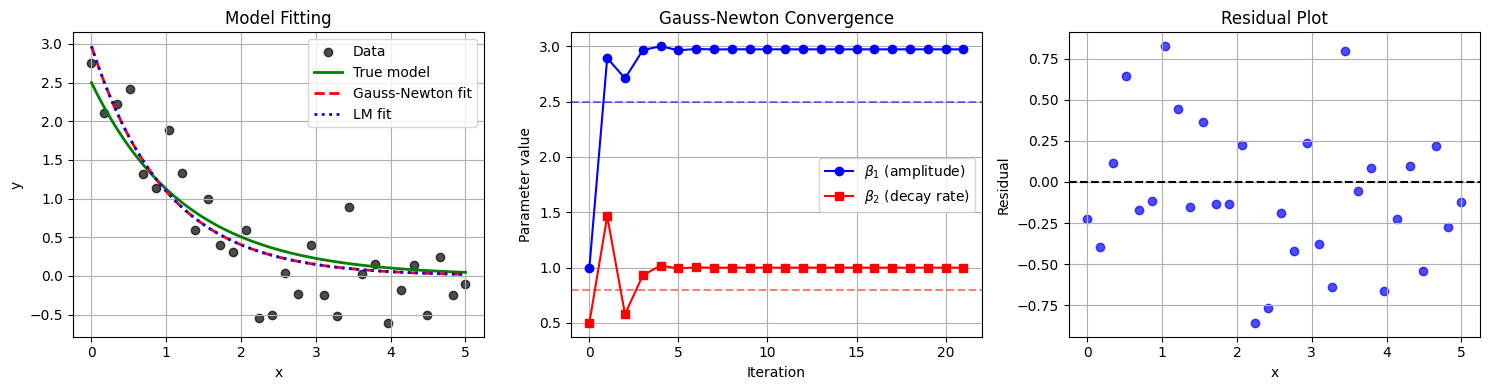


Sum of Squared Residuals: 5.5079


In [7]:
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Data and fitted curves
x_fine = np.linspace(a, b, 100)
axes[0].scatter(x_data, y_data, c='black', label='Data', alpha=0.7)
axes[0].plot(x_fine, exp_model(x_fine, true_beta), 'g-', label='True model', linewidth=2)
axes[0].plot(x_fine, exp_model(x_fine, beta_gn), 'r--', label='Gauss-Newton fit', linewidth=2)
axes[0].plot(x_fine, exp_model(x_fine, beta_lm), 'b:', label='LM fit', linewidth=2)
axes[0].set(xlabel='x', ylabel='y', title='Model Fitting')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Convergence of parameters (Gauss-Newton)
history_gn = np.array(history_gn)
axes[1].plot(history_gn[:, 0], 'b-o', label=r'$\beta_1$ (amplitude)')
axes[1].plot(history_gn[:, 1], 'r-s', label=r'$\beta_2$ (decay rate)')
axes[1].axhline(true_beta[0], color='b', linestyle='--', alpha=0.5)
axes[1].axhline(true_beta[1], color='r', linestyle='--', alpha=0.5)
axes[1].set(xlabel='Iteration', ylabel='Parameter value', title='Gauss-Newton Convergence')
axes[1].legend()
axes[1].grid(True)

# Plot 3: Residuals
residuals = y_data - exp_model(x_data, beta_gn)
axes[2].scatter(x_data, residuals, c='blue', alpha=0.7)
axes[2].axhline(0, color='black', linestyle='--')
axes[2].set(xlabel='x', ylabel='Residual', title='Residual Plot')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Summary statistics
ssr = np.sum(residuals**2)
print(f"\nSum of Squared Residuals: {ssr:.4f}")